In [87]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout,Activation
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.python.keras import metrics
from tensorflow.python import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE
import math
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support as sk
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import accuracy_score
import pandas as pd
import os
import sys
sys.path.append('C:\jupyter\Elementary-student-Weight')
%matplotlib inline

In [88]:
df_final=pd.read_csv("C:\jupyter\Elementary-student-Weight\jeju_weight\data\df_final_v2.csv",encoding="cp949")
df=pd.read_excel("C:\\jupyter\\Elementary-student-Weight\\jeju_weight\\data\\원본 데이터_통합본.xlsx",sheet_name=None)

In [89]:
df_final.isnull().sum()

ID                  0
collect_datetime    0
gender              0
grade               0
height              0
weight              0
step count          0
burned calorie      0
eat calorie         0
sleep time          0
dtype: int64

In [90]:
df_user = df['User']
df_body = df['Body']
df_offline = df['오프라인 측정 정보']
df_mediator = df['중재군 특별미션 정보']
df_stepcount = df['Step Count']
df_exercise = df['Exercise']
df_nutrition= df['Nutrition']
df_sleep= df['Sleep']
df_rewqrd= df['리워드 데이터']
df_competition=df['대결 데이터']

## BMI 변화 데이터 세트 셋팅

In [91]:
# 컬럼명 변경
df_offline.rename(columns={'학생정보':'ID','1차측정(9/11)': '1차측정_키', 'Unnamed: 3': '1차측정_몸무게', 'Unnamed: 4':'1차측정_BMI','2차측정(11/13)': '2차측정_키','Unnamed: 6': '2차측정_몸무게','Unnamed: 7':'2차측정_BMI'}, inplace=True)



In [92]:
df_offline = df_offline.drop(index=0)
df_offline = df_offline.dropna(subset=['2차측정_BMI'])
# 인덱스 재설정
df_offline.reset_index(drop=True, inplace=True)


In [93]:
# 2차 측정 BMI - 1차 측정 BMI 
df_offline['BMI차이']=df_offline['2차측정_BMI']-df_offline['1차측정_BMI']


In [94]:
df_offline

,ID,중재군 여부,1차측정_키,1차측정_몸무게,1차측정_BMI,2차측정_키,2차측정_몸무게,2차측정_BMI,비고,BMI차이
0,#VWOKVC,1,149.4,40.9,18.324077,151.5,41.4,18.037447,NaN,-0.28663
1,#WRCGLL,2,156.2,42,17.214215,156.4,42.1,17.211099,NaN,-0.003117
2,#BJVSCA,1,149.3,42.6,19.111289,150.7,44,19.374307,NaN,0.263018
3,#DDXWAS,2,152.4,40.5,17.437535,152.1,41.4,17.895421,NaN,0.457886
4,#PDBEAQ,1,153.5,67.6,28.68996,154.7,68.1,28.455517,NaN,-0.234442
...,...,...,...,...,...,...,...,...,...,...
72,#BJZXFO,1,139.3,34.3,17.676321,140.2,35.2,17.907981,NaN,0.23166
73,#MHEJKD,2,159.2,51.4,20.280422,160,51.5,20.117187,NaN,-0.163235
74,#FSGZCA,1,154.4,68.3,28.650098,154.7,73.7,30.795472,NaN,2.145374
75,#CPXSFR,1,153,68.1,29.091375,153.3,69.7,29.658451,NaN,0.567076


## Z-test,T-test

In [95]:
from scipy.stats import shapiro
from statsmodels.stats.weightstats import ztest as ztest
from scipy import stats
from scipy.stats import ttest_ind
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [96]:
df_BMI=df_offline[['중재군 여부','1차측정_BMI','2차측정_BMI']]

In [97]:
df_BMI

,중재군 여부,1차측정_BMI,2차측정_BMI
0,1,18.324077,18.037447
1,2,17.214215,17.211099
2,1,19.111289,19.374307
3,2,17.437535,17.895421
4,1,28.68996,28.455517
...,...,...,...
72,1,17.676321,17.907981
73,2,20.280422,20.117187
74,1,28.650098,30.795472
75,1,29.091375,29.658451


In [98]:
df_BMI.describe()

,중재군 여부,1차측정_BMI,2차측정_BMI
count,77,77.000000,77.000000
unique,2,77.000000,77.000000
top,2,18.324077,18.037447
freq,39,1.000000,1.000000


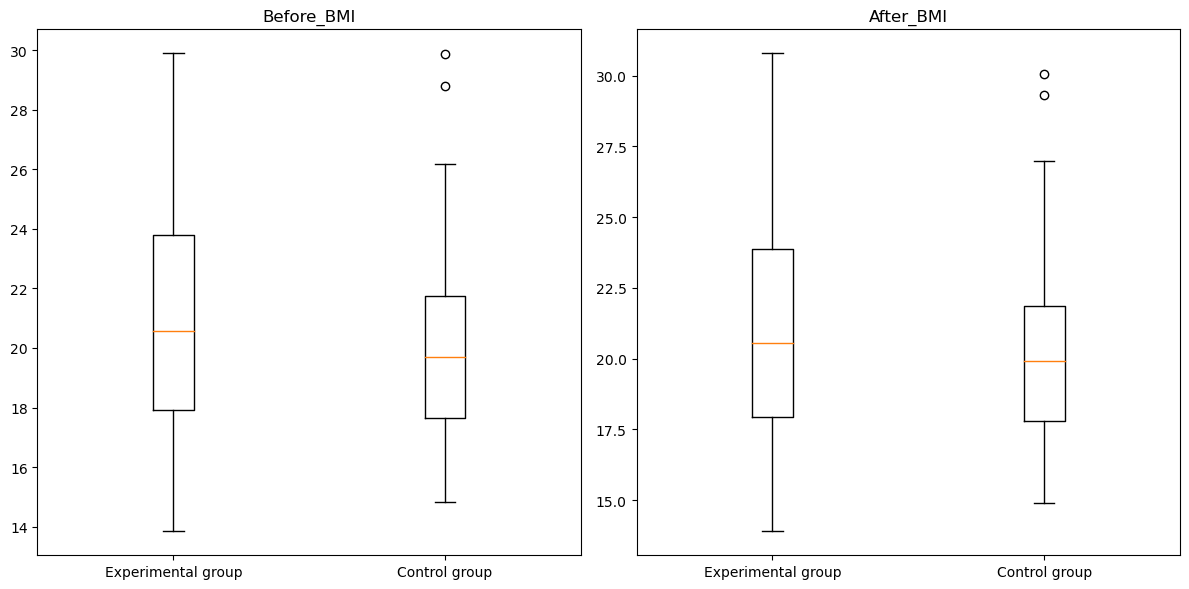

In [99]:
# 그룹별 박스 플롯 시각화

import pandas as pd
import matplotlib.pyplot as plt

# 데이터프레임 생성
data = {
    "중재군 여부":df_BMI['중재군 여부'],
    "1차측정_BMI": df_BMI['1차측정_BMI'],
    "2차측정_BMI": df_BMI['2차측정_BMI']
}

df = pd.DataFrame(data)

# 그룹별로 데이터 분리
group1 = df_BMI[df_BMI["중재군 여부"] == 1]
group2 = df_BMI[df_BMI["중재군 여부"] == 2]

# 박스 플롯 그리기
plt.figure(figsize=(12, 6))

# 1차측정_BMI 박스 플롯
plt.subplot(1, 2, 1)
plt.boxplot([group1["1차측정_BMI"], group2["1차측정_BMI"]], labels=["Experimental group", "Control group"])
plt.title("Before_BMI")

# 2차측정_BMI 박스 플롯
plt.subplot(1, 2, 2)
plt.boxplot([group1["2차측정_BMI"], group2["2차측정_BMI"]], labels=["Experimental group", "Control group"])
plt.title("After_BMI")

plt.tight_layout()
plt.show()


### Shapiro-Wilk Test 정규성 검정
각 집단이 정규분포를 따르는지 검증하는 실험   
H0 (귀무가설) : 표본의 모집단이 정규분포를 따른다.

vs.

HA (대립가설) : 표본의 모집단이 정규분포를 따르지 않는다.



유의 수준 0.05보다 크므로 귀무가설을 기각할 수 없으므로 정규성을 가지고 있다. 

In [100]:
print(shapiro(df_BMI[df_BMI['중재군 여부']==1]['1차측정_BMI']))
print(shapiro(df_BMI[df_BMI['중재군 여부']==1]['2차측정_BMI']))
print(shapiro(df_BMI[df_BMI['중재군 여부']==2]['1차측정_BMI']))
print(shapiro(df_BMI[df_BMI['중재군 여부']==2]['2차측정_BMI']))


ShapiroResult(statistic=0.9521816372871399, pvalue=0.10509586334228516)
ShapiroResult(statistic=0.9464405179023743, pvalue=0.0679931789636612)
ShapiroResult(statistic=0.9448894262313843, pvalue=0.05534635856747627)
ShapiroResult(statistic=0.9344024062156677, pvalue=0.024932866916060448)


### bartlett 등분산성 검정
p value가 0.05 이상으로 나왔기 때문에 등분산이라는 귀무가설을 선택

In [101]:
stats.bartlett(df_BMI[df_BMI['중재군 여부']==1]['1차측정_BMI'],df_BMI[df_BMI['중재군 여부']==1]['2차측정_BMI'],df_BMI[df_BMI['중재군 여부']==2]['1차측정_BMI'],df_BMI[df_BMI['중재군 여부']==2]['2차측정_BMI'])

BartlettResult(statistic=2.6607811866693742, pvalue=0.4469333157273985)

## 실험군과 대조군 BMI 차이 T-test
귀무가설: 실험군의 BMI 감소는 대조군의 BMI 감소와 차이가 없다. 
대립가설: 실험군의 BMI 감소가 대조군 보다 크다

In [105]:
df_offline

,ID,중재군 여부,1차측정_키,1차측정_몸무게,1차측정_BMI,2차측정_키,2차측정_몸무게,2차측정_BMI,비고,BMI차이
0,#VWOKVC,1,149.4,40.9,18.324077,151.5,41.4,18.037447,NaN,-0.28663
1,#WRCGLL,2,156.2,42,17.214215,156.4,42.1,17.211099,NaN,-0.003117
2,#BJVSCA,1,149.3,42.6,19.111289,150.7,44,19.374307,NaN,0.263018
3,#DDXWAS,2,152.4,40.5,17.437535,152.1,41.4,17.895421,NaN,0.457886
4,#PDBEAQ,1,153.5,67.6,28.68996,154.7,68.1,28.455517,NaN,-0.234442
...,...,...,...,...,...,...,...,...,...,...
72,#BJZXFO,1,139.3,34.3,17.676321,140.2,35.2,17.907981,NaN,0.23166
73,#MHEJKD,2,159.2,51.4,20.280422,160,51.5,20.117187,NaN,-0.163235
74,#FSGZCA,1,154.4,68.3,28.650098,154.7,73.7,30.795472,NaN,2.145374
75,#CPXSFR,1,153,68.1,29.091375,153.3,69.7,29.658451,NaN,0.567076


In [108]:

# t-검정 수행
t_stat, p_value = stats.ttest_ind(df_offline['1차측정_BMI'], df_offline['2차측정_BMI'], alternative='two-sided')

# 결과 출력
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# 유의수준 0.05와 비교하여 귀무가설 기각 여부 결정
# 결과 해석
alpha = 0.05
if p_value < alpha:
    print("대립가설을 채택합니다: 실험군의 평균 BMI 감소값이 대조군의 평균 BMI 감소값보다 작습니다.")
else:
    print("귀무가설을 채택합니다: 실험군의 평균 BMI 감소값은 대조군의 평균 BMI 감소값과 차이가 없습니다.")

T-statistic: -0.19210385325923576
P-value: 0.8479172624246067
귀무가설을 채택합니다: 실험군의 평균 BMI 감소값은 대조군의 평균 BMI 감소값과 차이가 없습니다.


In [102]:

# t-검정 수행
t_stat, p_value = stats.ttest_ind(df_offline[df_offline['중재군 여부']==2]['BMI차이'], df_offline[df_offline['중재군 여부']==1]['BMI차이'], alternative='less')

# 결과 출력
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# 유의수준 0.05와 비교하여 귀무가설 기각 여부 결정
# 결과 해석
alpha = 0.05
if p_value < alpha:
    print("대립가설을 채택합니다: 실험군의 평균 BMI 감소값이 대조군의 평균 BMI 감소값보다 작습니다.")
else:
    print("귀무가설을 채택합니다: 실험군의 평균 BMI 감소값은 대조군의 평균 BMI 감소값과 차이가 없습니다.")

T-statistic: -0.12471967475471542
P-value: 0.4505395824070759
귀무가설을 채택합니다: 실험군의 평균 BMI 감소값은 대조군의 평균 BMI 감소값과 차이가 없습니다.


In [103]:
# 자유도 계산
n_experimental = len(df_offline[df_offline['중재군 여부']==2]['BMI차이'])
n_control = len(df_offline[df_offline['중재군 여부']==1]['BMI차이'])
df = n_experimental + n_control - 2

# 임계값 계산 (단측 검정)      
t_critical = stats.t.ppf(1 - alpha, df)